# Corporate Credit Rating

In [43]:
#Import necessary packages

#For importing data
import pandas as pd

#For data preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

#For hyperparameter optimization
from sklearn.model_selection import GridSearchCV

#For mathematical operations
import numpy as np

#For data visualization
import matplotlib.pyplot as plt

#For dataset split
from sklearn.model_selection import KFold

#For model evaluation
from sklearn.metrics import accuracy_score, f1_score, r2_score

#For Randome Forest model
from sklearn.ensemble import RandomForestClassifier

#For SVM model
from sklearn.svm import SVC

#For GBDT
import xgboost

#For Logistic Regression
from sklearn.linear_model import LogisticRegression

#For Neural Network
from sklearn.neural_network import MLPClassifier

#For KNN
from sklearn.neighbors import KNeighborsClassifier

## Data Preprocessing (Part 1)

In [44]:
#Date import and cleansing

#Import the CSV data
df = pd.read_csv("corporateCreditRatingWithFinancialRatios.csv")

#Check if any missing values
num = len(df)
print("===== Data Cleansing =====")
print("Number of original data:", num)
print("Any missing values? ", df.isnull().values.any())
print(df["Rating"].unique())

#Drop unnecessary columns
print("Dropping unnecessary columns ...")
df = df.drop(["Rating Agency", "Corporation", "Ticker", "Binary Rating", "CIK", "SIC Code"], axis=1)

#Eliminate duplicated rows
df = df.drop_duplicates()
print("Duplicated rows dropped: ", num - len(df))

#Print first 5 rows after cleansing the dataset
df.head(5)

===== Data Cleansing =====
Number of original data: 7805
Any missing values?  False
['A-' 'AAA' 'BBB-' 'AA-' 'A' 'BBB+' 'BBB' 'BB' 'B' 'BB+' 'B+' 'BB-' 'B-'
 'A+' 'CCC' 'AA' 'CCC+' 'CC' 'C' 'CCC-' 'AA+' 'D' 'CC+']
Dropping unnecessary columns ...
Duplicated rows dropped:  2


,Rating,Rating Date,Sector,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,A-,2010-07-30,Utils,1.1507,0.4551,0.8847,77.6230,19.4839,19.4839,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.4530,1.9957,-0.1333
1,AAA,2010-09-16,BusEq,1.1129,0.0072,0.0073,43.6619,19.8327,19.8327,23.9379,20.8699,13.5690,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132
2,BBB-,2010-11-23,Shops,1.9276,0.2924,0.4255,11.9008,3.3173,3.3173,3.6338,3.0536,2.1418,2.4620,13.6376,16.7991,5.2731,9.6494,-7.6079,-7.3231
3,AA-,2010-06-29,Utils,0.8358,0.4708,0.9491,64.5096,18.4549,18.4549,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
4,A,2010-07-14,Shops,1.2931,0.2644,0.4036,3.8385,1.3269,1.3269,1.5847,1.2304,0.6518,4.9276,11.1256,19.4184,2.9364,8.1844,1.9725,2.4174


In [45]:
#rating mapping
rating_dict = {'AAA':'A_rank', 
               'AA+':'A_rank', 
               'AA':'A_rank', 
               'AA-':'A_rank',  
               'A+':'A_rank',  
               'A':'A_rank', 
               'A-':'A_rank', 
               'BBB+':'B_rank', 
               'BBB':'B_rank', 
               'BBB-':'B_rank', 
               'BB+':'B_rank', 
               'BB':'B_rank', 
               'BB-':'B_rank', 
               'B+':'B_rank', 
               'B':'B_rank',  
               'B-':'B_rank',  
               'CCC+':'C_rank', 
               'CCC':'C_rank', 
               'CCC-':'C_rank',
               'CC+':'C_rank',   
               'CC':'C_rank',
               'CC-':'C_rank',
               'C+':'C_rank',  
               'C':'C_rank',
               'C-':'C_rank',  
               'D':'D_rank', }

df["Rating"] = df["Rating"].map(rating_dict)
print(df.isnull().sum())

Rating                           0
Rating Date                      0
Sector                           0
Current Ratio                    0
Long-term Debt / Capital         0
Debt/Equity Ratio                0
Gross Margin                     0
Operating Margin                 0
EBIT Margin                      0
EBITDA Margin                    0
Pre-Tax Profit Margin            0
Net Profit Margin                0
Asset Turnover                   0
ROE - Return On Equity           0
Return On Tangible Equity        0
ROA - Return On Assets           0
ROI - Return On Investment       0
Operating Cash Flow Per Share    0
Free Cash Flow Per Share         0
dtype: int64


In [46]:
#Format convertion
sector_classes = df["Sector"].unique()
rating_classes = df["Rating"].unique()

#Turn categorical column into one-hot vectors
df = pd.get_dummies(df, columns=["Sector"], dtype=float) #Use df.iloc[:,17:29] to extract dummy columns for Sector
df = pd.get_dummies(df, columns=["Rating"], dtype=float) #Use df.iloc[:,29:] to extract dummy columns for Rating

#Transform strings in Rating Date Column into datetime format
df["Rating Date"] = pd.to_datetime(df["Rating Date"], format="%Y-%m-%d")

#Transform datetime in Rating Date Column into timestamp
df["Rating Date"] = df["Rating Date"].values.astype(np.int64)

#Print first 5 rows after transforming the dataset
df.head(5)

,Rating Date,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,...,Sector_Money,Sector_NoDur,Sector_Other,Sector_Shops,Sector_Telcm,Sector_Utils,Rating_A_rank,Rating_B_rank,Rating_C_rank,Rating_D_rank
0,1280448000000000000,1.1507,0.4551,0.8847,77.6230,19.4839,19.4839,28.9834,13.6093,8.3224,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1284595200000000000,1.1129,0.0072,0.0073,43.6619,19.8327,19.8327,23.9379,20.8699,13.5690,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1290470400000000000,1.9276,0.2924,0.4255,11.9008,3.3173,3.3173,3.6338,3.0536,2.1418,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1277769600000000000,0.8358,0.4708,0.9491,64.5096,18.4549,18.4549,27.9377,15.1135,9.0246,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,1279065600000000000,1.2931,0.2644,0.4036,3.8385,1.3269,1.3269,1.5847,1.2304,0.6518,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


## Data Exploration

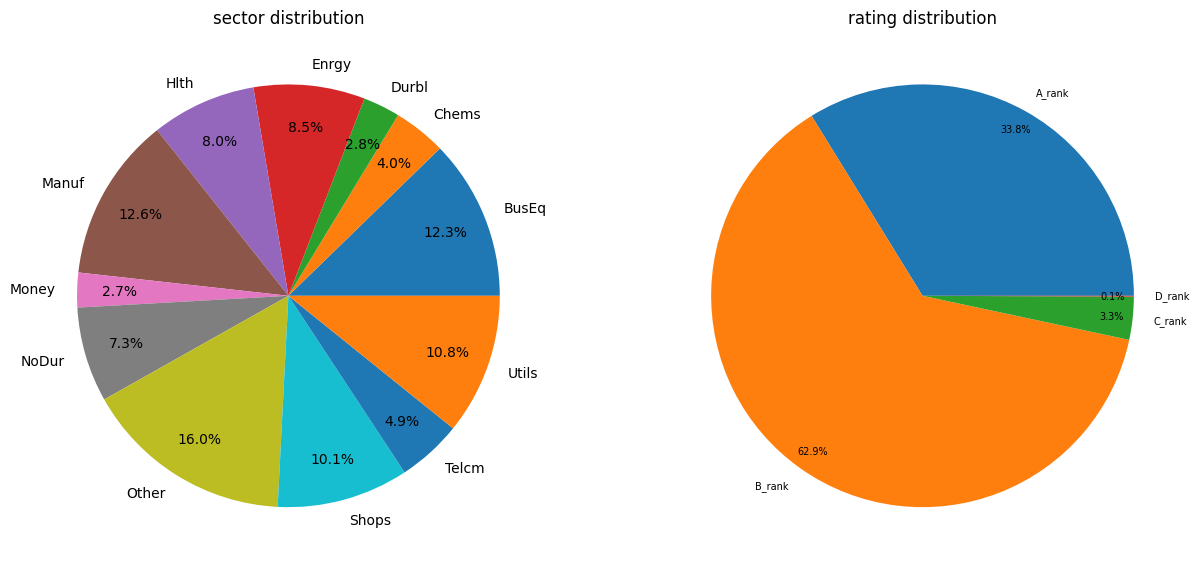

In [47]:
#Plotting the piecharts for visualizing sector & rating data

#Define the subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))

#Obtain sector & rating data
sector_distribution = df.iloc[:,17:29].sum()
rating_distribution = df.iloc[:,29:].sum()

#Sort the labels
sector_classes.sort()
rating_classes.sort()

#Define the pie chart for sector distribution
ax1.pie(sector_distribution, labels=sector_classes, autopct='%1.1f%%',pctdistance=0.8)
ax1.title.set_text('sector distribution')

#Define the pie chart for rating distribution
ax2.pie(rating_distribution, labels=rating_classes, autopct='%1.1f%%',pctdistance=0.9, textprops={'fontsize': 7})
ax2.title.set_text('rating distribution')

#Display the graph
plt.show()

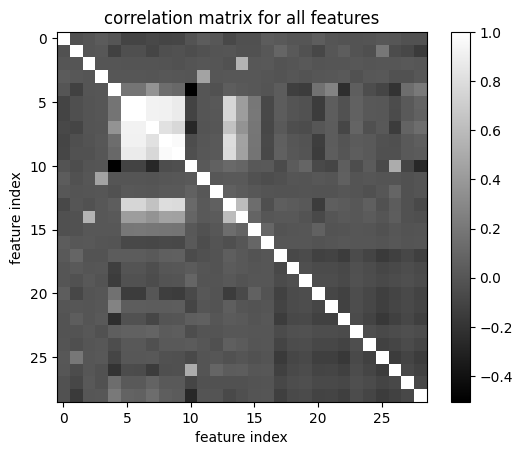

In [48]:
#Plotting the correlation matrix for features
feature_corr_matrix = df.iloc[:,:29].corr()
corr_plot = plt.imshow(feature_corr_matrix, cmap='gray')
plt.xlabel("feature index")
plt.ylabel("feature index")
plt.title("correlation matrix for all features")
plt.colorbar()
plt.show()

## Data Preprocessing (Part 2)

In [49]:
# Separate input features from labels
X = df.iloc[:, :29]
y = df.iloc[:, 29:]

# Define feature scalars
feature_scalers = [MinMaxScaler(feature_range=(0,1))]*len(X.iloc[1,:17])
scaler = MinMaxScaler()

# Train the scalars per column
for i in range(len(feature_scalers)):
    feature_scalers[i] = MinMaxScaler(feature_range=(0,1)).fit(X.iloc[:,i].values.reshape(-1, 1))

# Scale the data per column
X_scaled = X
for index, i in enumerate(X.iloc[:,:17].columns):
    X_scaled[i] = feature_scalers[index].transform(X.loc[:,[i]])

# Display top 5 rows of scaled dataset
print(X_scaled.head(5))

# Transform into nparrays
X_scaled = X_scaled.values
y = y.values

   Rating Date  Current Ratio  Long-term Debt / Capital  Debt/Equity Ratio   
0     0.046805       0.028783                  0.336685           0.883962  \
1     0.066341       0.027668                  0.334948           0.883436   
2     0.094017       0.051699                  0.336054           0.883687   
3     0.034188       0.019494                  0.336745           0.884001   
4     0.040293       0.032983                  0.335945           0.883673   

   Gross Margin  Operating Margin  EBIT Margin  EBITDA Margin   
0      0.880773          0.865938     0.865938       0.602185  \
1      0.699825          0.866566     0.866566       0.594390   
2      0.530598          0.836850     0.836850       0.563023   
3      0.810903          0.864087     0.864087       0.600569   
4      0.487641          0.833269     0.833269       0.559858   

   Pre-Tax Profit Margin  Net Profit Margin  ...  Sector_Durbl  Sector_Enrgy   
0               0.702165           0.667198  ...           0

/home/stevenoobplus/Templates/credit_rating/venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/stevenoobplus/Templates/credit_rating/venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/stevenoobplus/Templates/credit_rating/venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/stevenoobplus/Templates/credit_rating/venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/stevenoobplus/Templates/credit_rating/venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


## PCA Decomposition

In [50]:
# Perform PCA with the desired number of components
n_components = 24 # Specify the number of components you want to keep
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Use X_pca for further modeling or analysis

In [51]:
def grid_search(model, params, X, y, fold):
    gd_sr = GridSearchCV(model, params, cv=fold, scoring='accuracy')
    gd_sr.fit(X, y)
    print(gd_sr.best_params_)
    return 

In [52]:
def kf_train_test(name, model, df, X, y, fold):
    # create a KFold object with 5 folds
    kf = KFold(n_splits=fold, shuffle=True, random_state=1234)

    # initialize lists to store accuracy and R2 scores for each fold
    acc_scores = []
    r2_scores = []

    # loop over the folds
    for train_index, test_index in kf.split(df):
        # split the data into training and testing sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        y_train = np.argmax(y_train, axis=1)
        y_test = np.argmax(y_test, axis=1)

        # Create a Gradient Boost model
        model.fit(X_train, y_train)
    
        # make predictions on the testing set and compute accuracy and R2 score
        y_pred = model.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # append the scores to the lists for this fold
        acc_scores.append(acc_score)
        r2_scores.append(r2)

    # compute the average accuracy and R2 score across all folds
    avg_acc_score = sum(acc_scores) / len(acc_scores)
    avg_r2_score = sum(r2_scores) / len(r2_scores)

    return [avg_acc_score, avg_r2_score, model]

In [53]:
param_grids = {"Random Forest":[{ 
                    'bootstrap': [True],
                    'max_depth': [40],
                    'max_features': ['sqrt'],
                    'n_estimators': [600]
                    }],
               "GBDT":[{
                    'max_depth': [6],
                    'n_estimators': [180],
                    'learning_rate': [0.1],
               }]
               }

In [54]:
models = {"Random Forest":RandomForestClassifier(bootstrap=True, max_depth=40, max_features='sqrt', n_estimators=600, random_state=1234), 
          "GBDT":xgboost.XGBClassifier(max_depth=6, n_estimators=180, learning_rate=0.1)
          }

In [55]:
for (name, clf) in models.items():
        print(name)
        grid_search(clf, param_grids[name], X_pca, y, 10)
        print()

Random Forest


KeyboardInterrupt: 

In [ ]:
for (name, clf) in models.items():
    [avg_acc, avg_r2, res_clf] = kf_train_test(name, clf, df, X_pca, y, 10)
    print(name)
    print("Average Accuracy:", avg_acc)
    print("Average R2 Square:", avg_r2)
    print()

Random Forest
Average Accuracy: 0.8386496601989558
Average R2 Square: 0.40894817653941995

GBDT
Average Accuracy: 0.8449269509832888
Average R2 Square: 0.43676795786805495



/home/stevenoobplus/Templates/credit_rating/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/stevenoobplus/Templates/credit_rating/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/stevenoobplus/Templates/credit_rating/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/stevenoobplus/Templates/credit_rating/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

SVM
Average Accuracy: 0.6329607012705605
Average R2 Square: -0.32927442051390104



/home/stevenoobplus/Templates/credit_rating/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stevenoobplus/Templates/credit_rating/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Logistic Regression
Average Accuracy: 0.6726885321251519
Average R2 Square: -0.19440529363604347

MLP
Average Accuracy: 0.8008476969040348
Average R2 Square: 0.2751520811339593

KNN
Average Accuracy: 0.8181460323713845
Average R2 Square: 0.33834810344320604

